# Cargo Holds:  Clean or Dirty?
___

### Selective Data

The first model was based on the data cumulatively collected to be split between clean and dirty.  No segmentation was made to the specifics of the image.  Many images contain piping, ladders, hatch covers, tank tops, and or focused on people.

In this notebook, the model will focus on a narrowed dataset to just images of bulkheads.  These images were copied to a new directory called selective_data.  It was subdivided into a validation set (10%) and training set (90%).  
___

In [18]:
import os
import shutil

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator, smart_resize

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Rescaling, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay, auc

In [2]:
# sizing up the selected data
clean_path = '../data/selective_data/train/clean/'
clean_images = [i for i in os.listdir(clean_path)]

dirty_path = '../data/selective_data/train/dirty/'
dirty_images = [i for i in os.listdir(dirty_path)]

len(clean_images), len(dirty_images)

(250, 340)

In [3]:
# Holding back 25 and 34 random images from each class to serve as a test set.

# get ten random clean images
random.shuffle(clean_images)
test_clean_list = clean_images[:25]

# make a filepath
test_clean = []
for image in test_clean_list:
    test_clean.append(clean_path+image)

# move to test directory
for clean_image in test_clean:
    shutil.move(clean_image, '../data/selective_data/test/clean/')

# get ten random dirty images
random.shuffle(dirty_images)
test_dirty_list = dirty_images[:34]

# make a filepath
test_dirty = []
for image in test_dirty_list:
    test_dirty.append(dirty_path+image)

# move to test directory
for dirty_image in test_dirty:
    shutil.move(dirty_image, '../data/selective_data/test/dirty/')

In [4]:
num_clean = len([i for i in os.listdir('../data/selective_data/train/clean/')])
num_dirty = len([i for i in os.listdir('../data/selective_data/train/dirty/')])
num_clean, num_dirty

(225, 306)

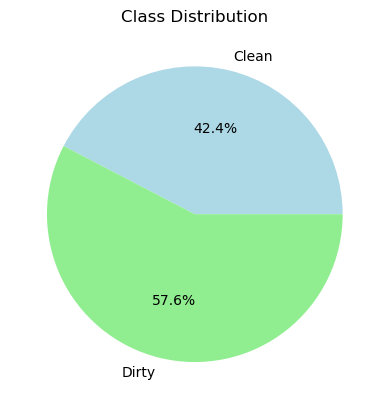

In [5]:
# Pie chart with class distribution
fig, ax = plt.subplots()
ax.pie(x=[num_clean, num_dirty], labels=['Clean', 'Dirty'], colors=['lightblue', 'lightgreen'], autopct='%1.1f%%')
ax.set_title('Class Distribution')
plt.show;

___
### Modeling

This time the dataset is smaller but more balanced.  This project has already questioned the size of the dataset so augmenting it with more synthetic data is not going to alleviate that concern.  For this workflow, the project will lean on validation split rather than manually creating training and validation sets.  Given it is a small dataset, we can still train on augmented data, so will generate some on the fly.  In order to do so, the validation set will have to undergo similar augmentations.  The test set though, remains isolated from augmentations (aside rescaling).

The model architecture will otherwise be nearly identical so as to isolate the data pipeline as the variation in training the model.  The other exception being that class weights are being tuned as the dataset is slightly imbalanced.

In [6]:
# create the image data generator to apply to the transformations to data
# the transformations are realistic as it relates to what could be seen
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    brightness_range=(0.7, 1.3),
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

model_target_size = (224, 224)
model_batch_size = 32

# Loading in image data
train_generator = train_datagen.flow_from_directory(
    '../data/selective_data/train/',
    target_size=model_target_size,
    batch_size=model_batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=27,
)

validation_generator = train_datagen.flow_from_directory(
    '../data/selective_data/train/',
    target_size=model_target_size,
    batch_size=model_batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=27,
)

Found 479 images belonging to 2 classes.
Found 52 images belonging to 2 classes.


In [7]:
# model for image classification
model = Sequential()
model.add(Input((224, 224, 3)))

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

# compile model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='bce', metrics=['accuracy', 'AUC', Precision(), Recall()])

# architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 32)     128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 64)                2

In [12]:
# fit model
class_weights = {0: 0.9, 1: 1.1}
checkpoint_path='../assets/saved_models/selective_models/'
checkpoint_accuracy = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1, save_weights_only=False)
checkpoint_recall = ModelCheckpoint(checkpoint_path + 'best_recall_model', monitor='val_recall', save_best_only=True, verbose=1, \
                                    save_weights_only=False, mode='max')
earlystopping = EarlyStopping(restore_best_weights=True, monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='min')
history = model.fit(train_generator, epochs=25, validation_data=validation_generator, class_weight=class_weights, callbacks=[earlystopping, checkpoint_accuracy, checkpoint_recall])

Epoch 1/25
15/15 [==============================] - ETA: 0s - loss: 0.6979 - accuracy: 0.6701 - auc: 0.7145 - precision: 0.7235 - recall: 0.6920
Epoch 1: val_accuracy improved from -inf to 0.53846, saving model to ../assets/saved_models/selective_models\


INFO:tensorflow:Assets written to: ../assets/saved_models/selective_models\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/selective_models\assets



Epoch 1: val_recall improved from -inf to 0.93333, saving model to ../assets/saved_models/selective_models\best_recall_model


INFO:tensorflow:Assets written to: ../assets/saved_models/selective_models\best_recall_model\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/selective_models\best_recall_model\assets


15/15 [==============================] - 84s 6s/step - loss: 0.6979 - accuracy: 0.6701 - auc: 0.7145 - precision: 0.7235 - recall: 0.6920 - val_loss: 0.7696 - val_accuracy: 0.5385 - val_auc: 0.4508 - val_precision: 0.5600 - val_recall: 0.9333
Epoch 2/25
15/15 [==============================] - ETA: 0s - loss: 0.6328 - accuracy: 0.7035 - auc: 0.7481 - precision: 0.7500 - recall: 0.7283
Epoch 2: val_accuracy improved from 0.53846 to 0.61538, saving model to ../assets/saved_models/selective_models\


INFO:tensorflow:Assets written to: ../assets/saved_models/selective_models\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/selective_models\assets



Epoch 2: val_recall improved from 0.93333 to 0.96667, saving model to ../assets/saved_models/selective_models\best_recall_model


INFO:tensorflow:Assets written to: ../assets/saved_models/selective_models\best_recall_model\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/selective_models\best_recall_model\assets


15/15 [==============================] - 80s 5s/step - loss: 0.6328 - accuracy: 0.7035 - auc: 0.7481 - precision: 0.7500 - recall: 0.7283 - val_loss: 0.7126 - val_accuracy: 0.6154 - val_auc: 0.5030 - val_precision: 0.6042 - val_recall: 0.9667
Epoch 3/25
15/15 [==============================] - ETA: 0s - loss: 0.6443 - accuracy: 0.7077 - auc: 0.7534 - precision: 0.7537 - recall: 0.7319
Epoch 3: val_accuracy did not improve from 0.61538

Epoch 3: val_recall did not improve from 0.96667
15/15 [==============================] - 72s 5s/step - loss: 0.6443 - accuracy: 0.7077 - auc: 0.7534 - precision: 0.7537 - recall: 0.7319 - val_loss: 0.7223 - val_accuracy: 0.5962 - val_auc: 0.5811 - val_precision: 0.5957 - val_recall: 0.9333
Epoch 4/25
15/15 [==============================] - ETA: 0s - loss: 0.6635 - accuracy: 0.6722 - auc: 0.7391 - precision: 0.7245 - recall: 0.6957
Epoch 4: val_accuracy did not improve from 0.61538

Epoch 4: val_recall did not improve from 0.96667
15/15 [===============

INFO:tensorflow:Assets written to: ../assets/saved_models/selective_models\best_recall_model\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/selective_models\best_recall_model\assets


15/15 [==============================] - 78s 5s/step - loss: 0.6309 - accuracy: 0.7035 - auc: 0.7662 - precision: 0.7557 - recall: 0.7174 - val_loss: 0.7220 - val_accuracy: 0.5769 - val_auc: 0.5659 - val_precision: 0.5769 - val_recall: 1.0000
Epoch 6/25
15/15 [==============================] - ETA: 0s - loss: 0.6862 - accuracy: 0.6555 - auc: 0.7046 - precision: 0.6975 - recall: 0.7101
Epoch 6: val_accuracy did not improve from 0.61538

Epoch 6: val_recall did not improve from 1.00000
15/15 [==============================] - 72s 5s/step - loss: 0.6862 - accuracy: 0.6555 - auc: 0.7046 - precision: 0.6975 - recall: 0.7101 - val_loss: 0.7119 - val_accuracy: 0.5769 - val_auc: 0.6045 - val_precision: 0.5769 - val_recall: 1.0000
Epoch 7/25
15/15 [==============================] - ETA: 0s - loss: 0.6352 - accuracy: 0.6806 - auc: 0.7437 - precision: 0.7189 - recall: 0.7319
Epoch 7: val_accuracy did not improve from 0.61538

Epoch 7: val_recall did not improve from 1.00000
15/15 [===============

INFO:tensorflow:Assets written to: ../assets/saved_models/selective_models\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/selective_models\assets



Epoch 12: val_recall did not improve from 1.00000
15/15 [==============================] - 76s 5s/step - loss: 0.6298 - accuracy: 0.6889 - auc: 0.7503 - precision: 0.7343 - recall: 0.7210 - val_loss: 0.7627 - val_accuracy: 0.6538 - val_auc: 0.5614 - val_precision: 0.6579 - val_recall: 0.8333
Epoch 13/25
15/15 [==============================] - ETA: 0s - loss: 0.5809 - accuracy: 0.7244 - auc: 0.7941 - precision: 0.7628 - recall: 0.7572
Epoch 13: val_accuracy did not improve from 0.65385

Epoch 13: val_recall did not improve from 1.00000
15/15 [==============================] - 72s 5s/step - loss: 0.5809 - accuracy: 0.7244 - auc: 0.7941 - precision: 0.7628 - recall: 0.7572 - val_loss: 0.8156 - val_accuracy: 0.5769 - val_auc: 0.5220 - val_precision: 0.6000 - val_recall: 0.8000
Epoch 14/25
15/15 [==============================] - ETA: 0s - loss: 0.5467 - accuracy: 0.7516 - auc: 0.8127 - precision: 0.7962 - recall: 0.7645
Epoch 14: val_accuracy improved from 0.65385 to 0.67308, saving mode

INFO:tensorflow:Assets written to: ../assets/saved_models/selective_models\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/selective_models\assets



Epoch 14: val_recall did not improve from 1.00000
15/15 [==============================] - 75s 5s/step - loss: 0.5467 - accuracy: 0.7516 - auc: 0.8127 - precision: 0.7962 - recall: 0.7645 - val_loss: 0.6420 - val_accuracy: 0.6731 - val_auc: 0.6174 - val_precision: 0.6757 - val_recall: 0.8333
Epoch 15/25
15/15 [==============================] - ETA: 0s - loss: 0.6035 - accuracy: 0.6973 - auc: 0.7842 - precision: 0.7549 - recall: 0.7029
Epoch 15: val_accuracy did not improve from 0.67308

Epoch 15: val_recall did not improve from 1.00000
15/15 [==============================] - 72s 5s/step - loss: 0.6035 - accuracy: 0.6973 - auc: 0.7842 - precision: 0.7549 - recall: 0.7029 - val_loss: 0.7452 - val_accuracy: 0.5962 - val_auc: 0.5508 - val_precision: 0.6047 - val_recall: 0.8667
Epoch 16/25
15/15 [==============================] - ETA: 0s - loss: 0.6513 - accuracy: 0.6868 - auc: 0.7421 - precision: 0.7316 - recall: 0.7210
Epoch 16: val_accuracy did not improve from 0.67308

Epoch 16: val_r

In [13]:
model.save('../assets/saved_models/selective_models/')

INFO:tensorflow:Assets written to: ../assets/saved_models/selective_models/assets


INFO:tensorflow:Assets written to: ../assets/saved_models/selective_models/assets


___
### Model Evaluation

As before, let's see how the model does on the test set and evaluate its metrics
___


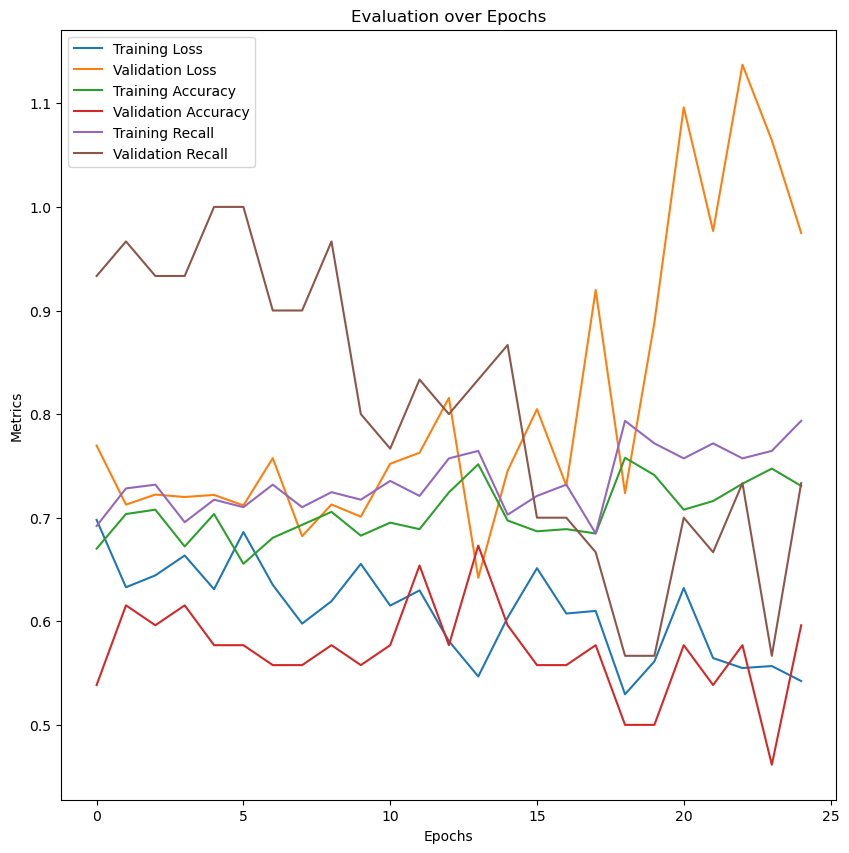

In [14]:
# plotting the training and validation metrics over epochs
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'], label='Training Loss', )
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Evaluation over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

In [15]:
# feed the test dataset to the model to generate predictions
test_datagen = ImageDataGenerator(
    rescale=1./255 # This is a necessary preprocessing step
)
test_generator = test_datagen.flow_from_directory(
    '../data/selective_data/test/',
    target_size=model_target_size,
    batch_size=model_batch_size,
    class_mode=None,
    shuffle=False
)

print(test_generator.class_indices)

Found 59 images belonging to 2 classes.
{'clean': 0, 'dirty': 1}


In [16]:
# make predictions
predictions = model.predict(test_generator, verbose=1)
predicted_class = (predictions > 0.5).astype(int)
class_labels = test_generator.classes
image_names = test_generator.filenames

# print image name and prediction
for image, pred_class in enumerate(predicted_class):
    print(f'Image {image_names[image]} predicted as class: {pred_class}')

2/2 [==============================] - 10s 3s/step
Image clean\0b80c8d6-b7ed-4d79-a706-998916e0a382.jpg predicted as class: [0]
Image clean\12c943_6ffd5c1009834472affd0ef243154370~mv2.jpg predicted as class: [0]
Image clean\148a4ab5-c8a0-408f-b303-d78ff890a2c7.jpg predicted as class: [1]
Image clean\26144fb8-bb65-45fb-9607-38f3b4cc2df1.jpg predicted as class: [0]
Image clean\27d568c2-6951-4792-b1a8-d7f302bc7675.jpg predicted as class: [0]
Image clean\3237fbcf-20fd-41ad-b1da-86a113666ba1.jpg predicted as class: [1]
Image clean\3325c33c-1417-4378-8068-31838ac99b3c.jpg predicted as class: [0]
Image clean\44fa87df-7c48-47ab-bfdb-ba2eae721489.jpg predicted as class: [1]
Image clean\4e80e264-2c52-41f8-acf5-e57b127730e5.jpg predicted as class: [1]
Image clean\4fe15594-8587-42aa-a193-20caf17959c1.jpg predicted as class: [1]
Image clean\68703372_2395345993845982_3371200627555172352_n.jpg predicted as class: [1]
Image clean\68743002_2395346160512632_100865468700557312_n.jpg predicted as class: [

Precision score: 0.71.
Recall score: 1.0.
F1 score: 0.83.


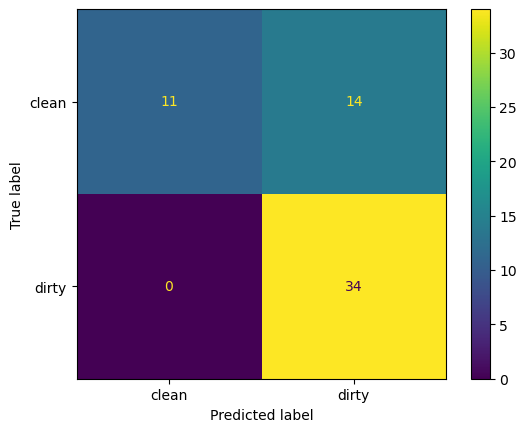

In [19]:
# evaluation metrics
precision = precision_score(class_labels, predicted_class)
recall = recall_score(class_labels, predicted_class)
f1_result = f1_score(class_labels, predicted_class)
confusing_matrix = confusion_matrix(class_labels, predicted_class)

print(f'Precision score: {round(precision, 2)}.')
print(f'Recall score: {round(recall, 2)}.')
print(f'F1 score: {round(f1_result, 2)}.')

cmd = ConfusionMatrixDisplay(confusion_matrix=confusing_matrix, display_labels=test_generator.class_indices)
cmd.plot();

In [20]:
# list of false negatives
false_negatives = []
print('False Negatives')
for image, pred_class in enumerate(predicted_class):
    if pred_class == 0:
        if pred_class != class_labels[image]:
            false_negatives.append(image_names[image])
            print(f'Image {image_names[image]} predicted class "clean" but labeled "dirty".')

False Negatives


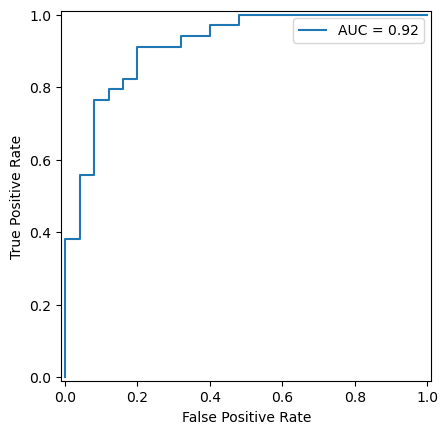

In [21]:
# Check the ROC Curve - will help us see how well the model is defining classes
fpr, tpr, thresholds = roc_curve(class_labels, predictions)
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot()
plt.legend()
plt.show;

In [22]:
# generate the roc_auc_score
roc_auc_score = round(roc_auc_score(class_labels, predictions), 4)
roc_auc_score

0.9153

___
### Model Evaluation  
  
___
##### Overfitting or Underfitting
This model displays alot of oscillation from epoch to epoch.  Also there isnt much of a c or v shape with metrics improving.  It is more reminiscent of waves.  This is an even smaller dataset so not very surprising.

After taking that into account, the model can be examined for signs of overfitting and underfitting.  One of the easiest signs of overfitting to detect is a noticeable difference between training and testing accuarcy.  This model is showing signs of overfitting as the gap between the training and validation accuracy is wide and growing.   Another sign that the model is overfitting is the performance on the test set is considerably better than the training and validation set accuracy.  While this might be luck or the dataset, it is also seen in the predictions as it seems to have known to predict dirty for every dirty test image.  It wasnt the same approach for the clean images (maybe a data leak, but doesnt appear so after checking).  Another sign of overfitting is when the validation loss function plateaus and increases while the training loss continues to fall.  Again, with a small validation set, it would not be surprising for the model to be too comfortable with the data.

The most obvious sign of underfitting, not performing well on training or validation accuaracy, was not clearly the case.  While the model was imbalanced by 7-8%, the accuracies were more than 10% of that finishin 73% and 60% respectively.  The training loss was falling while the validation loss was increasing, indicating the model is underfit.  The validation loss plateaued early, underfiting would be a concern as the model is not learning from the data to lower the loss.  Given this is a simple model, 32 filters on one convultional layer, concern that the model is not learning complex relationships exists.

Given the size of the dataset, the model architecture was kept lean to avoid overfitting to specific features.  The model will have to be adjusted should the size of th dataset increase substantially.
___
##### Predictions and Confusion Matrix

The confusion matrix returned interesting results with 0 true negatives, a perfect recall.  This is an issue rather than a great model.  The model has learned to guess dirty more often than not, the over sensitive metal detector comes to mind.

True Negatives = 11 (correctly predicted clean)
False Negatives = 0 (wrongly predicted clean)
False Positves = 14 (wrongly predicted dirty)
True Positives = 34 (correctly predicted dirty)
___
##### ROC AUC Curve
As mentioned earlier, 1.00 is the ideal score and 0.5 is bottom score.  A score of 0.75 would be average.  The model scored 0.9153 which would be good but is a consequence of the model being overfit to the dataset.
___
### More Modeling

While the results aren't satisfactory, they do leave some questions to explore:
* The model did not answer the question if a more selective data set would improve results.  It still could be the case, but more data is needed.  While augmenting data and oversampling can help, they can not become the crux of the solution, leading to fictional datasets.
* This leaves the question concerning transfer learning with a pre-trained model performing better?  

In the next notebook, we will try to answer this last question.
___